<a href="https://colab.research.google.com/github/BuczuTex/PRiR/blob/master/Lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Zadanie 1

In [ ]:
!pip install tensorflow-graphics
!pip install trimesh

     |████████████████████████████████| 348kB 6.0MB/s 
     |████████████████████████████████| 296kB 10.1MB/s 
     |████████████████████████████████| 634kB 8.4MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
  Created wheel for OpenEXR: filename=OpenEXR-1.3.2-cp36-cp36m-linux_x86_64.whl size=188437 sha256=f11b5d06bd78392711e77862a8536e50344885ea8dbb787353fe079e5aa31d51
  Stored in directory: /root/.cache/pip/wheels/41/06/9f/c7dc838815b0e7dfc7d7dc19cc3d677edb47594d8489adc62a
Successfully built OpenEXR
  Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import numpy as np
import tensorflow as tf
import trimesh
import gzip

import tensorflow_graphics.geometry.transformation as tfg_transformation
from tensorflow_graphics.notebooks import threejs_visualization

In [ ]:
!wget -N https://storage.googleapis.com/tensorflow-graphics/notebooks/index/cow.obj
!wget -N http://alice.loria.fr/data/unwrapped/LSCM_bunny.obj.gz
!wget -N http://alice.loria.fr/data/unwrapped/camel.obj.gz
!touch bunny.obj
!touch camel.obj

a_file = gzip.open("LSCM_bunny.obj.gz", "rb")
b_file = gzip.open("camel.obj.gz", "rb")

file2 = open("bunny.obj", "wb")
file2.writelines(a_file)

file3 = open("camel.obj", "wb")
file3.writelines(b_file)

file2.close()
file3.close()

a_file.close()
b_file.close()


mesh = trimesh.load("cow.obj")
mesh = {"vertices": mesh.vertices, "faces": mesh.faces}

mesh2 = trimesh.load("bunny.obj")
mesh2 = {"vertices": mesh2.vertices, "faces": mesh2.faces}

mesh3 = trimesh.load("camel.obj")
mesh3 = {"vertices": mesh3.vertices, "faces": mesh3.faces}

_1 = threejs_visualization.triangular_mesh_renderer(mesh2, width=400, height=400)
_2 = threejs_visualization.triangular_mesh_renderer(mesh3, width=400, height=400)

axis = np.array((0., 1., 0.))
angle = np.array((np.pi/4.,))
mesh2["vertices"] = tfg_transformation.axis_angle.rotate(mesh2["vertices"], axis,
                                                        angle).numpy()
mesh3["vertices"] = tfg_transformation.axis_angle.rotate(mesh3["vertices"], axis,
                                                        angle).numpy()


_ = threejs_visualization.triangular_mesh_renderer(mesh, width=400, height=400)
_1 = threejs_visualization.triangular_mesh_renderer(mesh2, width=400, height=400)
_2 = threejs_visualization.triangular_mesh_renderer(mesh3, width=400, height=400)

#Zadanie 2

##DeepDream

"DeepDream to eksperyment, który wizualizuje wzorce wyuczone przez sieć neuronową. Podobnie jak wtedy, gdy dziecko obserwuje chmury i próbuje zinterpretować przypadkowe kształty, DeepDream nadinterpretuje i ulepsza wzory, które widzi na obrazie.
<br>
Odbywa się to poprzez przekazywanie obrazu przez sieć, a następnie obliczanie gradientu obrazu w odniesieniu do aktywacji określonej warstwy. Obraz jest następnie modyfikowany, aby zwiększyć te aktywacje, wzmacniając wzorce widziane przez sieć i dając w rezultacie obraz przypominający sen. Proces ten nazwano „Incepcjalizmem”."
<br>Źródło + kod: https://www.tensorflow.org/tutorials/generative/deepdream
<br>Jest to podobne do algorytmu NTS z tą różnicą, że inputem tutaj jest jeden obraz, a w algorytmie NTS mamy dwa inputy: obraz, który chce się przerobić oraz obraz, który jest stylem dla przerabianego obrazu. W tym algorytmie liczymy gradienty dla obrazu, żeby wyglądał podobnie do snu.

In [ ]:
import tensorflow as tf

import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'


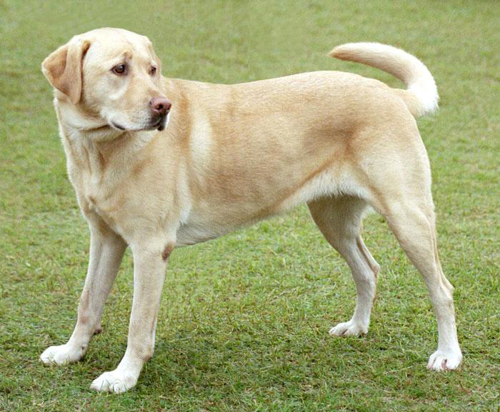

In [ ]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))


In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [ ]:
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)


In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

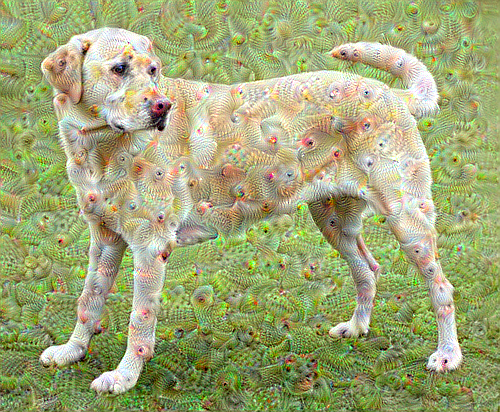

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)